In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets
import tqdm
import numpy as np
from sklearn.utils import shuffle
from time import perf_counter

In [2]:
# old code in naming means that it uses my class as an realisation of htde

In [3]:
try:
    from ht.ht import *
except:
    !git clone https://github.com/a-wernon/htde.git

    from htde.ht.ht import *


fatal: destination path 'htde' already exists and is not an empty directory.


In [4]:
#same as in launch.ipynb, but in single function, to measure performance

In [5]:
class HTModel(nn.Module):
    def __init__(self, alpha, basis_functions, device='cpu'):
        super(HTModel, self).__init__()
        self.device = device
        self.alpha = HTuckerNode(alpha, make_optim=True, device=self.device) #инитим рандомно пока, тут хранятся коэффициенты
        self.basis_functions = basis_functions
    def forward(self, x):
        
        #тут нужно в иксе вычислить значения всех базисных функций. В итоге это тензор ранга 1, как я понимаю
        phi_big = HTuckerNode(self.basis_functions.get_val(x, device=self.device), device=self.device)
        
        out = self.alpha.scalar_product(phi_big) # scalar, size (1,1,1,1)
        return out #torch.pow(out, 2), add it later
    
def my_loss(model, x, debug=False):
    # это вычисление нашего интегрального лосса в точке
    ds = 0 #нужно получить матрицу D по формуле из иксов
    #кажется, что в случае базиса фурье это просто единичная матрица, поэтому пока опустим.
    comp_1 = model.alpha.scalar_product(model.alpha)
    comp_2 = -2 * model(x)
    
    if debug:
        print(comp_1, comp_2)
    
    return torch.mean(comp_1 + comp_2)

In [6]:
def launch_code(basic_size, hidden_dim, n_epochs=100, batch_size=100, lr=1e-3, ds_size=1000, device='cpu', plot_result=True, track_time=False):
    content_sample = [
        [
            [
                torch.Tensor(np.random.rand(1, basic_size, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, basic_size, 1))
            ],
        torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
            [
                torch.Tensor(np.random.rand(1, basic_size, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, basic_size, 1))
            ]
        ],
        torch.Tensor(np.random.rand(hidden_dim, 1, hidden_dim)),
        [
            [
                torch.Tensor(np.random.rand(1, basic_size, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, basic_size, 1))
            ],
            torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
            [
                torch.Tensor(np.random.rand(1, basic_size, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, hidden_dim, hidden_dim)),
                torch.Tensor(np.random.rand(hidden_dim, basic_size, 1))
            ]
        ]
    ]
    
    
    functional_content = [
        [
            [
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
                ,
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
            ],
            [
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
                ,
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
            ]    
        ],
        [
            [
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
                ,
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
            ],
            [
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
                ,
                FuncList(
                    [fourier_basis(i) for i in range(basic_size)]
                )
            ]    
        ]
    ]
    
    device = device
    #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    basis_functions = FunctionalHTuckerNode(functional_content)

    if track_time:
        start_time = perf_counter()
    # need to rewrite all of the model interfaces in future
    model = HTModel(content_sample, basis_functions, device=device).to(device)

    criterion = my_loss

    #print(model)
    
    optimizer = torch.optim.Adam(model.alpha.get_params_for_optim(), lr = lr)
    
    mock_data = np.random.normal(size = (ds_size, 8))
    
    mock_data -= mock_data.mean(axis = 0)
    mock_data *= ((np.pi - 1) / np.abs(mock_data).max(axis = 0))
    
    epochs = n_epochs
    batch_size = batch_size
    loss = 0

    losses = []

    for i in tqdm.tqdm(range(epochs)):
        cum_losses = []
        loss = 0
        ds = shuffle(mock_data)
        for j in range(len(ds) // batch_size):

            loss += criterion(model, ds[j * batch_size: (j + 1) * batch_size])

            #print(loss)


            loss_fin = loss
            #print(loss.shape)

            loss_fin.backward()

            cum_losses.append(loss_fin.cpu().detach().numpy())

            loss = 0
            optimizer.step()
            optimizer.zero_grad()

        losses.append(np.mean(cum_losses) / batch_size)
    
    if plot_result:
        plt.plot(losses[:])
        plt.yscale('log')

    if track_time:
        return perf_counter() - start_time

In [7]:
cpu = torch.device('cpu')
gpu = torch.device('cuda')

In [8]:
basic_size = 256
hidden_dims = [2, 4, 8, 16, 32, 64, 128, 256]
n_epochs = 100
ds_size = 10000
batch_size = 1000

cpu_time = []
gpu_time = []

for hidden_dim in hidden_dims:

    cpu_time.append(
        launch_code(
            basic_size=basic_size, 
            hidden_dim=hidden_dim, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            lr=1e-2, 
            ds_size=ds_size, 
            device=cpu, 
            plot_result=False, 
            track_time=True
        )
    )

    gpu_time.append(
        launch_code(
            basic_size=basic_size, 
            hidden_dim=hidden_dim, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            lr=1e-2, 
            ds_size=ds_size, 
            device=gpu, 
            plot_result=False, 
            track_time=True
        )
    )



 21%|██        | 21/100 [14:35<54:52, 41.67s/it]


KeyboardInterrupt: ignored

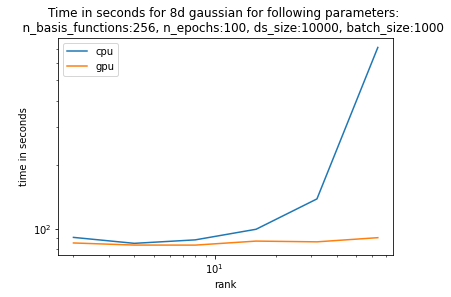

In [10]:
plt.title(
    f'''Time in seconds for 8d gaussian for following parameters: 
    n_basis_functions:{basic_size}, n_epochs:{n_epochs}, ds_size:{ds_size}, batch_size:{1000}'''
)
plt.plot(hidden_dims[:6], cpu_time, label='cpu')
plt.plot(hidden_dims[:6], gpu_time, label='gpu')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('rank')
plt.ylabel('time in seconds');